# Reproduce CheXNet: Explore Predictions

## Import other modules and pandas

In [2]:
import visualize_prediction as V

import pandas as pd

#suppress pytorch warnings about source code changes
import warnings
warnings.filterwarnings('ignore')

## Settings for review
We can examine individual results in more detail, seeing probabilities of disease for test images. 

We get you started with a small number of the images from the large NIH dataset. 

To explore the full dataset, [download images from NIH (large, ~40gb compressed)](https://nihcc.app.box.com/v/ChestXray-NIHCC), extract all tar.gz files to a single folder, place that path  below and set STARTER_IMAGES=False

In [3]:
STARTER_IMAGES=True
PATH_TO_IMAGES = "starter_images/"

#STARTER_IMAGES=False
#PATH_TO_IMAGES = "your path to NIH data here"

Load pretrained model (part of cloned repo; should not need to change path unless you want to point to one you retrained)

In [4]:
PATH_TO_MODEL = "pretrained/checkpoint"

Pick the finding you want to see positive examples of:

LABEL can be set to any of:
- Atelectasis
- Cardiomegaly
- Consolidation
- Edema
- Effusion
- Emphysema
- Fibrosis
- Hernia
- Infiltration
- Mass
- Nodule
- Pleural_Thickening
- Pneumonia
- Pneumothorax


In [5]:
LABEL="Pneumonia"

It's more interesting when initially exploring to see cases positive for pathology of interest:

In [6]:
POSITIVE_FINDINGS_ONLY=True

## Load data

This loads up dataloader and model (note: only test images not used for model training are loaded).

In [51]:
dataloader,model= V.load_data(PATH_TO_IMAGES,LABEL,PATH_TO_MODEL,POSITIVE_FINDINGS_ONLY,STARTER_IMAGES)
print("Cases for review:")
print(len(dataloader))

Cases for review:
32


## Examine individual cases

To explore, run code below to see a random case positive for your selected finding, a heatmap indicating the most influential regions of the image, and the model's estimated probabilities for findings. For many diagnoses, you can see that the model uses features outside the expected region to calibrate its predictions -- [you can read my discussion about this here](https://medium.com/@jrzech/what-are-radiological-deep-learning-models-actually-learning-f97a546c5b98).

Please note that:
1) the NIH dataset was noisily labeled by automatically extracting labels from text reports written by radiologists, as described in paper [here](https://arxiv.org/pdf/1705.02315.pdf) and analyzed [here](https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/), so we should not be surprised to see inaccuracies in the provided ground truth labels 
2) high AUCs can be achieved even if many positive cases are assigned absolutely low probabilities of disease, as AUC depends on the relative ranking of probabilities between cases. 

You can run the below cell repeatedly to see different examples:

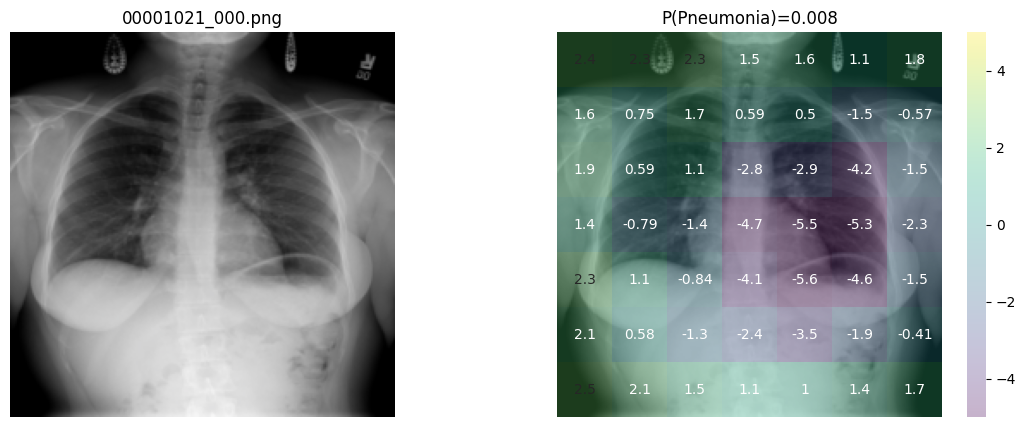

,Predicted Probability,Ground Truth
Finding,,
Infiltration,0.078,False
Nodule,0.059,False
Mass,0.018,False
Atelectasis,0.011,False
Consolidation,0.011,False
Pneumonia,0.008,True
Cardiomegaly,0.005,False
Effusion,0.005,False
Fibrosis,0.005,False


In [27]:
preds=V.show_next(dataloader,model, LABEL)
preds

In [110]:

import torch
checkpoint = torch.load(PATH_TO_MODEL, map_location=lambda storage, loc: storage)
model = checkpoint['model']
del checkpoint
model.cpu()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [111]:
import cxr_dataset as CXR
from torchvision import datasets, models, transforms

In [112]:
checkpoint = torch.load(PATH_TO_MODEL, map_location=lambda storage, loc: storage)
model = checkpoint['model']
del checkpoint
model.cpu()

# build dataloader on test
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

FINDINGS = [
    'Atelectasis',
    'Cardiomegaly',
    'Effusion',
    'Infiltration',
    'Mass',
    'Nodule',
    'Pneumonia',
    'Pneumothorax',
    'Consolidation',
    'Edema',
    'Emphysema',
    'Fibrosis',
    'Pleural_Thickening',
    'Hernia']

data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

finding = LABEL

dataset = CXR.CXRDataset(
    path_to_images=PATH_TO_IMAGES,
    fold='test',
    transform=data_transform,
    # finding=finding,
    starter_images=STARTER_IMAGES)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=1)

In [113]:
len(dataloader)

621

In [114]:
class densenet_last_layer(torch.nn.Module):
    def __init__(self, model):
        super(densenet_last_layer, self).__init__()
        self.features = torch.nn.Sequential(
            *list(model.children())[:-1]
        )

    def forward(self, x):
        x = self.features(x)
        x_relu = torch.nn.functional.relu(x, inplace=True)
        return x, x_relu

In [120]:
import numpy as np
images, labels, name = next(iter(dataloader))
print(images.shape, labels, name)
x = images
model_cam = densenet_last_layer(model)
y, y_relu = model_cam(x)
pooled = torch.nn.functional.adaptive_avg_pool2d(y, (1, 1))
y.shape, pooled.shape

torch.Size([1, 3, 224, 224]) tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32) ('00000075_000.png',)


(torch.Size([1, 1024, 7, 7]), torch.Size([1, 1024, 1, 1]))